# Neural Networks - Deep Learning 
## Project 3)


Ονοματεπώνυμο: Κωνσταντίνος - Ηλιας Χονδρορρίζος

Α.Ε.Μ.: 3812

In [1]:
#Importing the libraries i'm going to use
import gzip
import time
import math
import random as rd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette = "Spectral")

import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
from keras import layers

from sklearn.decomposition import PCA

## Loading - Preprocessing

In [2]:
"""
parameters:
@imageFile: the .gz file with the image vectors.
@labelFile: the .gz file with label vectors
@Filesize: the number of images and labels to be loaded
    Unzips the .gz file and loads the contents of them into the arrays.
    
return:
@ImageArray: A numpy array of the loaded images  (28x28)
@LabelArray: A numpy array of the labels
"""
def LoadData(imageFile,labelFile,Filesize):
    
    imageFile = gzip.open(imageFile,'r')
    imageFile.read(16)
    
    labelFile = gzip.open(labelFile,'r')
    labelFile.read(8)
    
    
    LabelArray=[]
    ImageArray=[]
    
    count=0
    while(count!=Filesize):
        
        #One pair image-label per iteration.
        label=np.frombuffer(labelFile.read(1), dtype=np.uint8).astype(np.int64)
        
        image = np.frombuffer(imageFile.read(28 * 28), dtype=np.uint8).astype(np.float32)
            
        ImageArray.append(image.reshape(28,28))
        LabelArray.append(label[0])
            
        count+=1
        
    return np.asarray(ImageArray),np.asarray(LabelArray)

In [3]:
"""
parameters:
@data: data to be plotted, in this case it is an image
    This function plot and displaya single image.
    
return:
None
"""
def Plot(data):
    image = np.asarray(data).squeeze()
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()


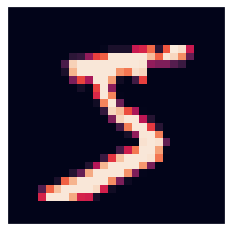

In [4]:
limit_train = 10000
limit_test = 1000

X_test,y_test = LoadData('test_images.gz', 'test_labels.gz', limit_test)

X_train,y_train = LoadData('train_images.gz', 'train_labels.gz',limit_train)
Plot(X_train[0])

In [5]:
X_train = X_train.reshape(limit_train, X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(limit_test, X_test.shape[1]*X_test.shape[2])

X_train = X_train/255

X_test =  X_test/255

print(f"Min value :{min(X_train[0])} ,Max value: {max(X_train[0])}")

Min value :0.0 ,Max value: 1.0


In [6]:
"""
parameters:
@f: the decorated function
    A decorator function that calculates the running time of another given function.

return:
@result: the result of the wrapped function.
@full_time: the time it took the f function to run in seconds.
"""
def timing(f):
    def wrapper(*args,**kwargs):
        start = time.time()
        result = f(*args,**kwargs)
        end = time.time()
        full_time = float(end-start)
        return result , full_time
    return wrapper

In [7]:
"""
parameters:
@listOfAlgs:A list of algorithms.
@training_times: A list containing the training time of the algorithms in listOfAlgs.
    Generates and displays a bar plot for algorithm training time using the provided lists.
    
return:
None
"""
def BarPlots(listOfAlgs,training_times):

    plt.figure(figsize=(15,6))

    sns.barplot(data = {"x" : listOfAlgs ,"y" : training_times } ,x = "y" , y = "x")
    plt.xlabel("Seconds")
    plt.legend(["Training time"])

    plt.show()

In [8]:
"""
parameters:
@X : The data
@dimension : The embedded space.
    Applies PCA to reduce the number of dimensions in the X data and decodes them back again.
return:
The transformed dataset after applying PCA and the runnig time of the function.
"""
@timing
def Pca(X,dimension):
    p = PCA(n_components=dimension)
    p.fit(X)
    X_reduced = p.transform(X)
    
    return p.inverse_transform(X_reduced)
    

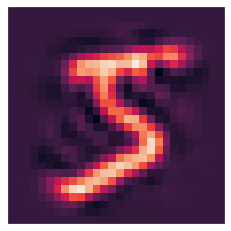

In [9]:
a,t= Pca(X_train,80)
Plot(a[0].reshape(28,28))

## Auto-encoder Class.

In [10]:
class MyAutoEncoder:
    
    """
    parameters:
    @input_shape : the shape of input data.
    @layers : list of integers specifying the number of neurons in each layer of the autoencoder.
    @output_function : activation function for output layer.
    @hidden_function : activation function for hidden layers.

        Initializes the class attributes and creates the autoencoder model.
    """
    def __init__(self ,input_shape ,layers ,output_function = "sigmoid" ,hidden_function = "relu"):
        self.layers = layers
        self.input_shape = input_shape
        self.input_layer = Input(shape=(self.input_shape,))
        self.latent_space = None
    
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.Create_Autoencoder(output_function ,hidden_function)
        
    
    """
    parameters:
    @output_function : activation function for output layer.
    @hidden_function : activation function for hidden layers.
        Creates the autoencoder,encoder and decoder models based on the layers array we provided.
    
    return:
    none
    """
        
    def Create_Autoencoder(self ,output_function ,hidden_function):
        
        x = self.input_layer
        for i in range(0, len(self.layers)-1):
            x = Dense(self.layers[i], activation = hidden_function)(x)
        self.latent_space = Dense(self.layers[-1], activation = hidden_function)(x)
        
        x = self.latent_space
        for i in range(0, len(self.layers)-1):
            x = Dense(self.layers[i], activation = hidden_function)(x)
        output_1 = Dense(self.input_shape, activation = output_function)(x)

        self.autoencoder = Model(inputs=self.input_layer, outputs=output_1)
        
        self.Create_Encoder()
        self.Create_Decoder()
        self.Compile_Model()
        
        
    """
    parameters:
    none
        Cretes the encoder model based on the first(Input) and the middle(latent) layers.
    return:
    none
    """    
    def Create_Encoder(self):
        self.encoder = Model(inputs=self.input_layer, outputs=self.latent_space)
    
    
    """
    parameters:
    none
        Cretes the decoder model by reversing the layers of the auto-encoder and keeps se second half of them.
    return:
    none
    """  
    def Create_Decoder(self):
        
        decoder_input = self.latent_space
        
        num = math.ceil(len(self.autoencoder.layers)/2)
        x = decoder_input
        for layer in self.autoencoder.layers[num:-1]:
            x = layer(x)
        decoder_output = self.autoencoder.layers[-1](x)
        
        self.decoder = Model(decoder_input, decoder_output)
        
        
    """
    parameters:
    none
        Compliles the model using the mean squared error loss function and the adam optimizer.
    return:
    none
    """     
    def Compile_Model(self):
        self.autoencoder.compile(loss = 'MSE', optimizer='adam')
        
        
    """
    parameters:
    @X_train : The training data.
    @X_test : The testing data.
    @epochs : The number of iteration to train the model.
    @verb : The verbosity level.
        Fits the auto-encoder with the training data and decodes back the encoded_imgs.
        
    return:
    @decoded_imgs : The decoded images from the input training data and the training time.
    """   
    @timing
    def Fit_and_predict(self ,X_train ,X_test ,epochs=10 , verb = 1):
        
        self.autoencoder.fit(X_train, X_train, epochs=epochs ,verbose = verb )
        
        encoded_imgs = self.encoder.predict(X_test,verbose=0)
        decoded_imgs = self.decoder.predict(encoded_imgs,verbose=0)
        return decoded_imgs
    
    
    """
    parameters:
    none
        Summarizes the auto-encoder.
    return:
    none
    """  
    def Auto_summary(self):
        self.autoencoder.summary()
        
    """
    parameters:
    none
        Summarizes the encoder.
    return:
    none
    """      
    def Encoder_summary(self):
        self.encoder.summary()
        
    """
    parameters:
    none
        Summarizes the decoder.
    return:
    none
    """      
    def Decoder_summary(self):
        self.decoder.summary()
    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
 dense_2 (Dense)             (None, 32)                96        
                                                                 
 dense_3 (Dense)             (None, 784)               25872     
                                                                 
Total params: 51,154
Trainable params: 51,154
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
313/313 [==============================] - 2s 

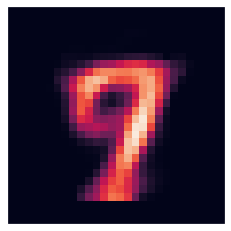

In [11]:
auto = MyAutoEncoder(X_train.shape[1],[32,2])
auto.Auto_summary()
values, _ = auto.Fit_and_predict(X_train,X_test, epochs=10)
Plot(values[0].reshape(28,28))

## Compare Pca and Auto-Encoder.

In [12]:
"""
parameters:
@index : A list of integers specifying the index of images to be plotted.
@decoded_values : The decoded images returned from the autoencoder.
@layers : list of integers specifying the number of neurons in each layer of the autoencoder.
    Plots 10 decoded images using the index provided.
    
return:
    none
"""
def Print_results(index,decoded_values,title):
        
        fig, axes = plt.subplots(1,10,figsize=(16,6))
        count = 0
        for i in index:
            axes[count].set_title(y_test[i])
            axes[count].imshow(decoded_values[i].reshape(28,28))
            axes[count].set_xticks([])
            axes[count].set_yticks([])
            count += 1
        plt.suptitle(title,y=0.68)
        plt.show()

### Εmbedded at 2.

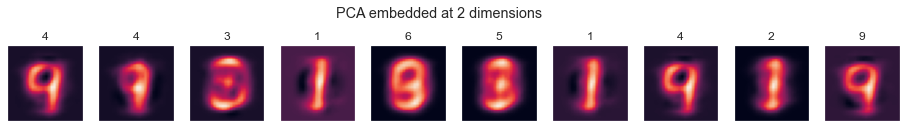

In [13]:
indexs = np.random.randint(limit_test, size=10)

values,_= Pca(X_test,2)
Print_results(indexs,values,"PCA embedded at 2 dimensions")

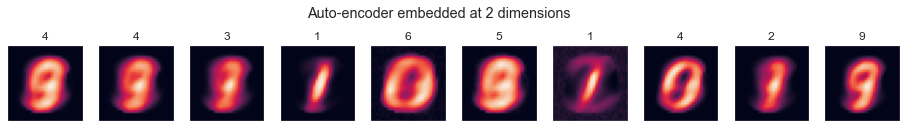

In [14]:
auto = MyAutoEncoder(X_train.shape[1],[2])
values, _ = auto.Fit_and_predict(X_train,X_test, epochs=10 ,verb = 0)
Print_results(indexs,values,"Auto-encoder embedded at 2 dimensions")

### Εmbedded at 24.

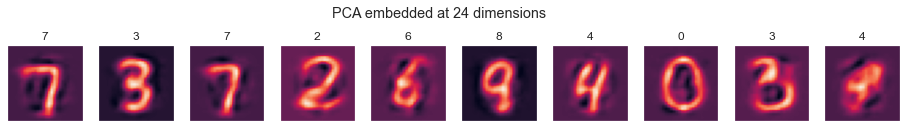

In [15]:
indexs = np.random.randint(limit_test, size=10)

values,_= Pca(X_test,24)
Print_results(indexs,values,"PCA embedded at 24 dimensions")

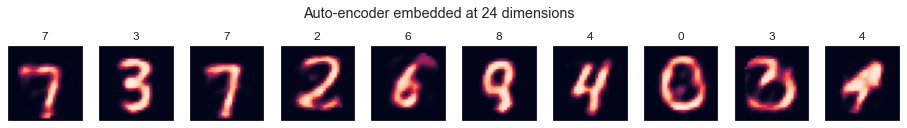

In [16]:
auto = MyAutoEncoder(X_train.shape[1],[24])
values, _= auto.Fit_and_predict(X_train ,X_test ,epochs=10 ,verb = 0)
Print_results(indexs,values,"Auto-encoder embedded at 24 dimensions")

### Εmbedded at 100.

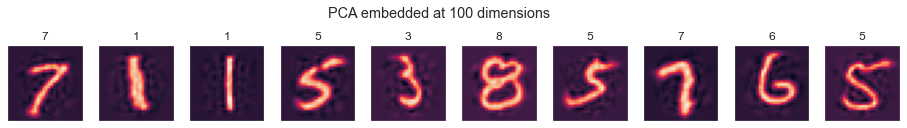

In [18]:
indexs = np.random.randint(limit_test, size=10)

values,total_timePCA= Pca(X_test,100)
Print_results(indexs,values,"PCA embedded at 100 dimensions")

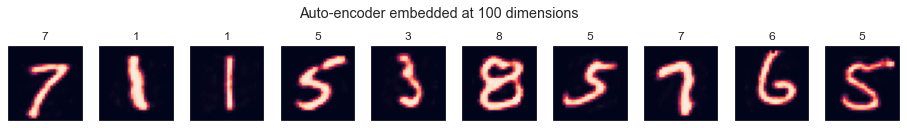

In [19]:
auto = MyAutoEncoder(X_train.shape[1],[100])
values,_ = auto.Fit_and_predict(X_train,X_test, epochs=10 ,verb = 0)
Print_results(indexs,values,"Auto-encoder embedded at 100 dimensions")

## Compare different : number of layers/epochs and activation functions.

### Different number of layers.

In [20]:
layers1 = [12]

auto1 = MyAutoEncoder(X_train.shape[1],layers1)
values1, total_time1 = auto1.Fit_and_predict(X_train ,X_test, epochs=10 ,verb = 0)

In [21]:
layers2 = [98,2]

auto2 = MyAutoEncoder(X_train.shape[1],layers2)
values2, total_time2 = auto2.Fit_and_predict(X_train,X_test, epochs=10 ,verb = 0)

In [22]:
layers3 = [98,49,12]

auto3 = MyAutoEncoder(X_train.shape[1],layers3)
values3, total_time3 = auto3.Fit_and_predict(X_train,X_test, epochs=10 ,verb = 0)

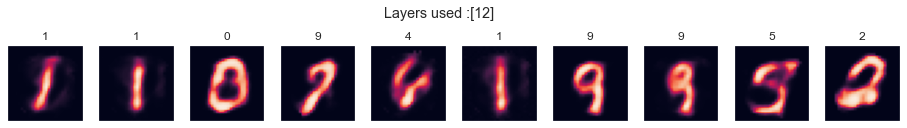

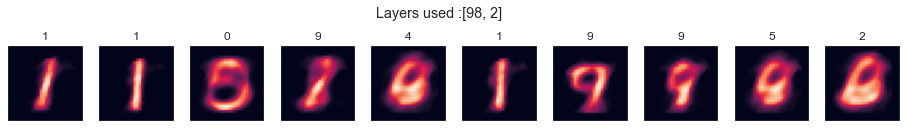

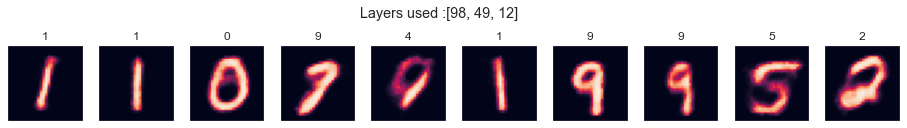

In [23]:
indexs = np.random.randint(limit_test, size=10)

Print_results(indexs,values1,f"Layers used :{layers1}")
Print_results(indexs,values2,f"Layers used :{layers2}")
Print_results(indexs,values3,f"Layers used :{layers3}")

### Compare training times.

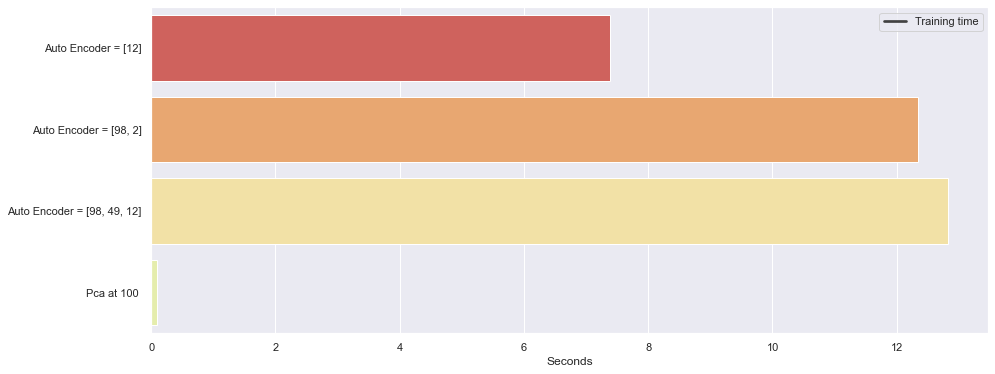

In [24]:
Total_time = []

Total_time.append(total_time1)
Total_time.append(total_time2)
Total_time.append(total_time3)
Total_time.append(total_timePCA)


BarPlots([f"Auto Encoder = {layers1}",f"Auto Encoder = {layers2}",f"Auto Encoder = {layers3}",f"Pca at 100 "],Total_time)

### Compare different activation functions and epochs number.

### Activision functions.

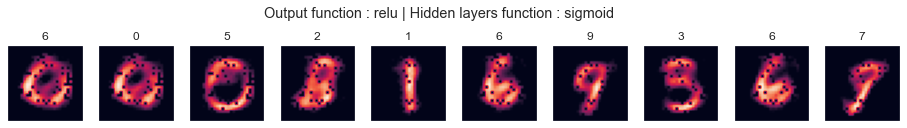

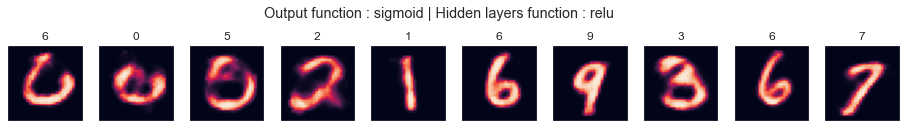

In [25]:
layers = [98,49,12]

auto = MyAutoEncoder(X_train.shape[1],layers,output_function = "relu" ,hidden_function = "sigmoid")
values, _ = auto.Fit_and_predict(X_train,X_test, epochs=10 ,verb = 0)



indexs = np.random.randint(limit_test, size=10)
Print_results(indexs,values,"Output function : relu | Hidden layers function : sigmoid")
Print_results(indexs,values3,"Output function : sigmoid | Hidden layers function : relu")

### Epochs

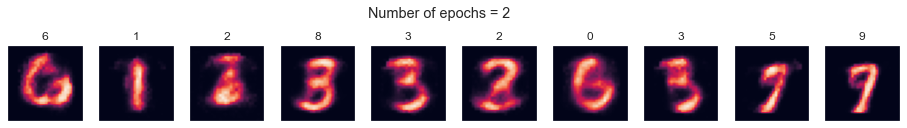

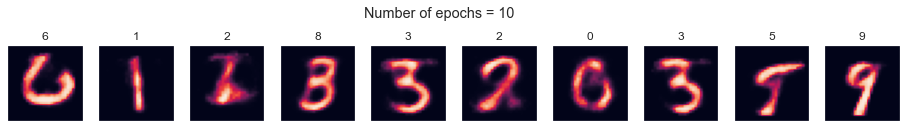

In [26]:
auto = MyAutoEncoder(X_train.shape[1],layers)
values, _ = auto.Fit_and_predict(X_train,X_test,epochs=2,verb = 0)


indexs = np.random.randint(limit_test, size=10)
Print_results(indexs,values,"Number of epochs = 2")
Print_results(indexs,values3,"Number of epochs = 10")